# Logistic Regression

Matthew Mella

12/05/23

In [1]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
import pandas as pd
import statsmodels.api as sm
import time
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris

## Problem 1

Create a classifier called `LogiReg` that accepts an $(n \times 1)$ array $y$ of binary labels ($0$'s and $1$'s) as well as an $(n \times d)$ array $X$ of data points. Write a `fit()` method that finds and saves the optimal $\widehat{\boldsymbol{\beta}}$.

## Problem 2

Write a method called `predict_prob()` that accepts an $(n \times d)$ array $x\_test$ and returns $P(Y=1 | x\_test)$. Also write a method called `predict()` that calls `predict_prob()` and returns an array of predicted labels ($0$'s or $1$'s) for the given array $x\_test$.

In [38]:
class LogiReg(): 
    
    def fit(self, X, y):
        """
        input:
        X: ndarray(n, d)
        y: ndarray(n, 1) taking values only in {0,1}
        
        Save y and X as attributes.
        Updates beta, the coefficient array of shape (d, 1) that
        minimizes the negative log likelihood for the given data 
        with the model p(y|x) = sigm(x^T @ beta).      
        """
        # Define the sigmoid function
        self.sigm = lambda x: 1 / (1 + np.exp(-x))


        X = np.hstack((np.ones((X.shape[0], 1)), X))
        beta0 = np.zeros(X.shape[1])

        # Define the negative log likelihood function
        def nll(beta):
            z = X @ beta
            epsilon = 1e-9  # Small constant to prevent log(0)
            return np.sum(y * -np.log(self.sigm(z) + epsilon) + (1 - y) * -np.log(self.sigm(-z) + epsilon))

        # Minimize the negative log likelihood
        res = minimize(nll, beta0)
        self.beta = res.x
        self.X = X
        self.y = y


        
    def predict_prob(self, x_test):
        """
        Returns the predicted probability of an input x_test.
        If x_test has shape (p, q), then the predicted probability
        has shape (1, q).
        """
        # Add a column of ones to x_test
        x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))
        # Return the predicted probability
        return self.sigm(x_test @ self.beta)
        
        
    def predict(self, x_test):
        """
        Returns the predicted classification (1 or 0) of x_test.
        If x_test has shape (p, q), then the predicted classification
        has shape (1, q).
        """      
        return self.predict_prob(x_test) >= 0.5

## Problem 3

Test your classifier from the previous two problems using arrays $X$, $y$, and $X\_test$. Train your classifier on $X$ and $y$. Then generate a list of predicted labels using your trained classifier and $X\_test$, and use it to plot $X\_test$ with a different color for each predicted label.

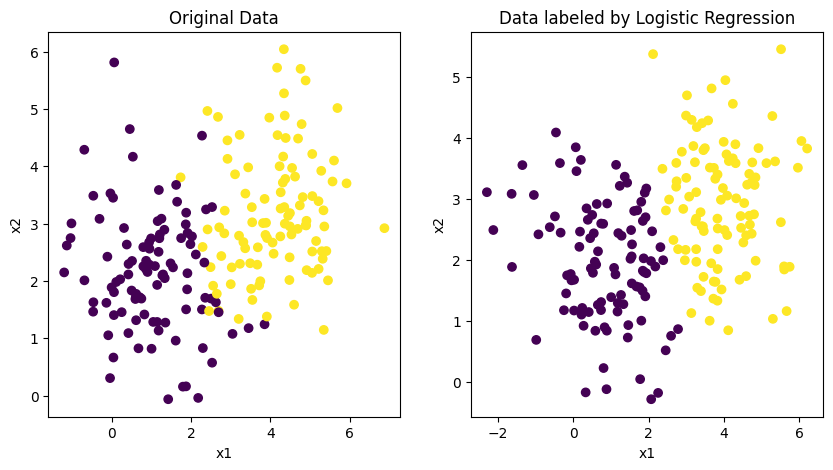

In [39]:
data = np.column_stack(( 
    np.concatenate(( 
        # draw from 2 2-dim. multivariate normal dists.
        np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
        np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) )), 
    # labels corresonding to each distribution
    np.concatenate(( np.zeros(100), np.ones(100) )) ))
np.random.shuffle(data)
# extract X and y from the shuffled data
X = data[:,:2]
y = data[:,2].astype(int)

X_test = np.concatenate(( 
    # draw from 2 identical 2-dim. multivariate normal dists.
    np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
    np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) ))
np.random.shuffle(X_test)


# fit the model
model = LogiReg()
model.fit(X, y)
# predict the labels of the test data
y_pred = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot the data
ax1.scatter(X[:,0], X[:,1], c=y)
ax1.set_title("Original Data")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

# plot the predicted labels
ax2.scatter(X_test[:,0], X_test[:,1], c=y_pred)
ax2.set_title("Data labeled by Logistic Regression")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")

plt.show()

## Problem 4

Using each of `LogiReg`, `statsmodels.Logit`, `sklearn.LogisticRegression`, and `sklearn.svm` train a logistic regression classifier on $X$ and $y$ to generate a list of predicted labels for $X\_test$. Then, using $y\_test$, print the accuracy scores for each trained model. Compare the accuracies and training/testing time for all three classifiers. Be sure to add a constant feature with each model.

In [107]:
# predefine the true beta
beta = np.random.normal(0, 7, 20)

# X is generated from 2 20-dim. multivariate normal dists.
X = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20)*2, np.eye(20), 100) ))
np.random.shuffle(X)
# create y based on the true beta
pred = 1. / (1. + np.exp(-X @ beta))  
y = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

# X_test and y_test are generated similar to X and y
X_test = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20), np.eye(20), 100) ))
np.random.shuffle(X_test)
pred = 1. / (1. + np.exp(-X_test @ beta))
y_test = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

# create a LogiReg model
model = LogiReg()

# fit the model and time it
start = time.time()

model.fit(X, y)

end = time.time()

print("Time to fit the model: ", end-start)

# predict the labels of the test data
y_pred = model.predict(X_test)

# print the accuracy of the model
print('Accuracy of the LogiReg model: ', accuracy_score(y_test, y_pred))


# create a statsmodels Logit model
model = sm.Logit(y, sm.add_constant(X))

# fit the model and time it
start = time.time()

result = model.fit_regularized(disp=0, RuntimeWarning='ignore')
        
end = time.time()

print("Time to fit the model: ", end-start)

# predict the labels of the test data
y_pred = result.predict(sm.add_constant(X_test)) >= 0.5
# print the accuracy of the model
print('Accuracy of the statsmodels Logit model: ', accuracy_score(y_test, y_pred))


# create a sklearn LogisticRegression model
model = LogisticRegression()

# fit the model and time it
start = time.time()

model.fit(X, y)

end = time.time()

print("Time to fit the model: ", end-start)

# predict the labels of the test data
y_pred = model.predict(X_test)

# print the accuracy of the model
print('Accuracy of the sklearn LogisticRegression model: ', accuracy_score(y_test, y_pred))


# create a SVM model
model = svm.SVC(kernel='linear')

# fit the model and time it
start = time.time()

model.fit(sm.add_constant(X), y)
        
end = time.time()

print("Time to fit the model: ", end-start)

# predict the labels of the test data
y_pred = model.predict(sm.add_constant(X_test))

# print the accuracy of the model
print('Accuracy of the sklearn SVM model: ', accuracy_score(y_test, y_pred))



Time to fit the model:  0.033300161361694336
Accuracy of the LogiReg model:  0.94
Time to fit the model:  0.008211851119995117
Accuracy of the statsmodels Logit model:  0.95
Time to fit the model:  0.001840353012084961
Accuracy of the sklearn LogisticRegression model:  0.965
Time to fit the model:  0.0017023086547851562
Accuracy of the sklearn SVM model:  0.95


/opt/homebrew/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


## Problem 5

Import the Iris Dataset and perform a train-test split on only the first two columns of the data with `test_size=0.4`. Train a multinomial logistic regression model using the training data with an added constant feature, and generate prediction labels for the test data.

Plot the test data by color using your prediction labels. Also, print the model score

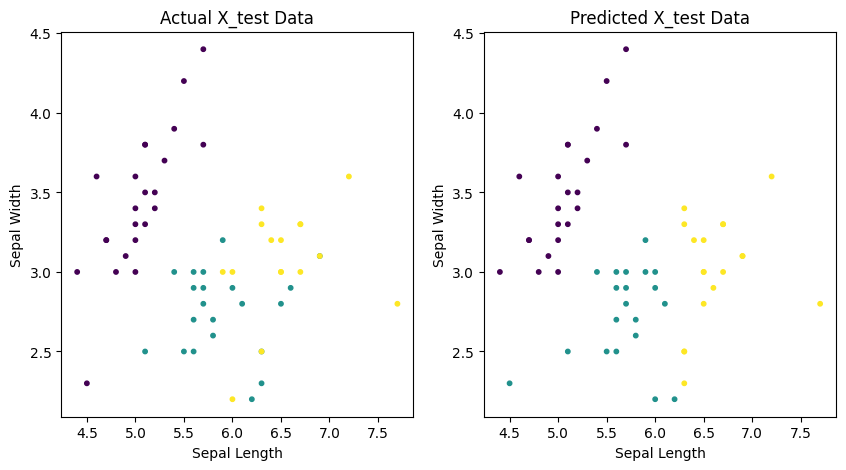

In [108]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.4)

# create a LogisticRegression model
model = LogisticRegression(
    multi_class='multinomial',
    fit_intercept=True,
).fit(X_train, y_train)

# predict the labels of the test data
model.predict(X_test)

# print the model score
model.score(X_test, y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot the X_test data
ax1.scatter(X_test[:,0], X_test[:,1], c=y_test, s=10)
ax1.set_title("Actual X_test Data")
ax1.set_xlabel("Sepal Length")
ax1.set_ylabel("Sepal Width")

# plot the predicted labels
ax2.scatter(X_test[:,0], X_test[:,1], c=model.predict(X_test), s=10)
ax2.set_title("Predicted X_test Data")
ax2.set_xlabel("Sepal Length")
ax2.set_ylabel("Sepal Width")

plt.show()